In [0]:
#start by defining the paths to the style-reference image and the target image 
!pip install numpy==1.16.2


from google.colab import drive
drive.mount('/content/gdrive')

from keras.preprocessing.image import load_img, img_to_array

#target_image_path = 'img/portrait.jpg'
target_image_path = '/content/gdrive/My Drive/portrait.jpg'

#insert path
#style_reference_image_path = 'img/transfer_style_reference.jpg'
style_reference_image_path = '/content/gdrive/My Drive/transfer_style_reference.jpg'

#resize to 400px new demensions 
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


Insert auxiliary functions for loading, preprocessing and postprocessing the images that go into the VGG19 convnet

In [0]:
#!pip install numpy==1.16.2

import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
  img = load_img(image_path, target_size = (img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg19.preprocess_input(img)
  return img

#zero centering by removing the mean pixel value from ImageNet. This reverses a transformation done by vgg19.preprocess_input
def deprocess_image(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68
  
  #convert images from BGR --> RGB 
  x = x[:,:, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

Now we move on to setting up the VGG19 network. The input is a batch of 3 images (content target, style reference, place holder for generated image). The place holder is a symbolic tensor and will its values will be provided externally through via Numpy arrays. Th other two images will be defined using K.constant since they are static. The values within the placeholder of the generated image will change ovet time.  




In [0]:
from keras import backend as K 


target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
#creating place holder for generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

#combine the 3 images into one single batch
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis = 0)

#builds the VGG19 network w/ batch of three images as input. Model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor = input_tensor, weights = 'imagenet', include_top = False)

print('Model loaded.')


Instructions for updating:
Colocations handled automatically by placer.
Model loaded.


Time to define the content loss. This will make sure that the top layer of the VGG19 convnet has a similar view of the target image and the generated image.

In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

Next we have the style loss. It uses an auxiliary function to compute the Gram matrix of an input matrix which is a map of the correlations found in the original feature matrix.

In [0]:
def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S-C)) / (4. * (channels ** 2) * (size ** 2))


We will now add a third loss component to the previous 2. The total variation loss, which operates on the pixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results. We can interpret it as a reqularization loss. 

In [0]:
def total_variation_loss(x):
  a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))



The loss that we minimize is a weighted average of these three losses. In order to compute the content loss, we use only one upper layer - the block5_conv2 layer - whereas for the style loss you use a list of layers that span both low-level and high level layers. You add the total variation loss at the end. Depending on the style-reference image and content image that we are using, we will likely want to tune the content_weight coefficient (contribution of the content loss to the total loss). A higher content_weight means the target content will be more recognizable in the generated image. 

In [0]:
#dictionary that will map the layer names to the activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
#layer for content loss
content_layer = 'block5_conv2'
#layers for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

#weights in the weighted average of the loss components 
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

#add content loss
#define loss by adding all components to this scalar variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

#add a style loss component for each target layer
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  s1 = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * s1
  
#add the total variation loss
loss += total_variation_weight * total_variation_loss(combination_image)



Now lets set up the gradient-descent process. We will use the L-BFGS algorithm. The algorithm comes packaged with SciPy and that only has two limitations:
1) it requires that you pass the value of the loss function and the value of the gradients as two seperate functions
2) it can only be applied to flat vectors, whereas you have a 3D image array

It is inefficient to compute the value of the loss function and the value of the gradients independently, because by doing so it would lead to a lot of redundant computation between the two. Process would be twice as slow. To improve efficiency we will set up a python class names Evaluator that will compute both the loss value and the gradients value at once --> returns the loss value when called the first time --> caches the gradients for the next call

In [0]:
#gets the gradients of the generated image with regard to the loss
grads = K.gradients(loss, combination_image)[0]

#function will fetch the values of the current loss and the current gradients 
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

#build class that will wrap fetch_loss_and_grads in a way that lets you retrieve the losses and gradients via two seperate method calls, which is required by the SciPy optimizer that we use.
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
    
  def loss(self, x):
    assert self.loss_value is None 
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value
  
  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
  
evaluator = Evaluator()

    
   


Finally, we run the gradient-ascent process using SciPy's L-BFGS algorithm, saving the current generated image at each iteration of the algorithm - single iteration represents 20 steps of gradient ascent

  ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
Start of iteration 0
Current loss value: 3542956000.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 434s


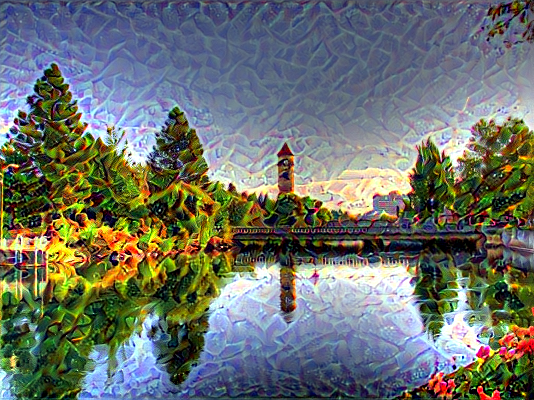

Start of iteration 1
Current loss value: 1167428000.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 436s


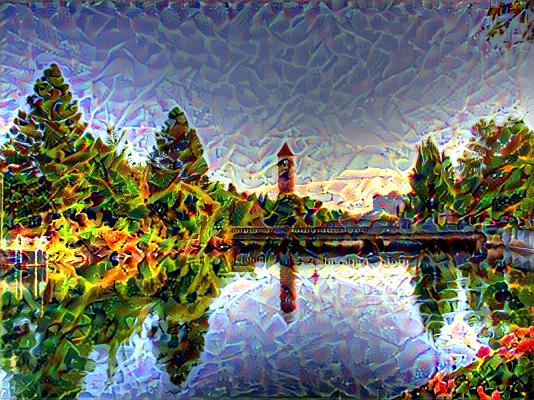

Start of iteration 2


KeyboardInterrupt: ignored

In [0]:

!pip install upgrade tensorflow

!pip install scipy
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imwrite
import time
!pip install imageio 
import imageio 


result_prefix = 'my_result'
iterations = 20

#initial state: target image
x = preprocess_image(target_image_path)

#flatten bcs scipy.optimie fmin_1_bfgs_b can only optimize flat vectors
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()

  # run L-BFGS optimization over pixels of the generated image to minimize the neural style loss. 
  # you have to pass the the function that computes the loss and the function that computes the gradients as two seperate arguments
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime = evaluator.grads, maxfun = 20)
  print('Current loss value:', min_val)
  
  #save current generated images
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  #imsave(fname, img)
  imageio.imwrite(fname, img) 
  
  print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))
  
  from IPython.display import Image, display
  
  display(Image('my_result_at_iteration_%d.png' % i))
  

